In [4]:
import numpy as np
import pandas as pd
import plotly.express as px
import time
import os
import psutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial
import sys
from base_path import base_path
sys.path.insert(0, f'{base_path}/adaptive/source_code')
sys.path.insert(0, f'{base_path}/disaggregated/source_code')

# Import our adaptive module:
adaptive_MDP = __import__('adaptive_MDP', globals=None, locals=None, fromlist=(), level=0)
poly_utils = __import__('poly_utils', globals=None, locals=None, fromlist=(), level=0)
Adaptive = adaptive_MDP.Adaptive

# Import non adaptive modules to compare:
non_adaptive = __import__('non_adaptive', globals=None, locals=None, fromlist=(), level=0)
poly_utils = __import__('poly_utils', globals=None, locals=None, fromlist=(), level=0)
NonAdaptive = non_adaptive.NonAdaptive

In [4]:
def elapsed_since(start):
    return time.strftime("%H:%M:%S", time.gmtime(time.time() - start))


def get_process_memory():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss


def track(func):
    def wrapper(*args, **kwargs):
        mem_before = get_process_memory()
        start = time.time()
        result = func(*args, **kwargs)
        elapsed_time = elapsed_since(start)
        mem_after = get_process_memory()
        print("{}: memory before: {:,}, after: {:,}, consumed: {:,}; exec time: {}".format(
            func.__name__,
            mem_before, mem_after, mem_after - mem_before,
            elapsed_time))
        return result
    return wrapper

### Examples to initialize

In [ ]:
# # ================================================== #

# # Initial parameters (Example from Fenichel et al):
# mu = 0
# gamma = 0.1823
# beta = 0.0825
# phi = 0

# # R values:
# Rmu = mu/(mu+ gamma)
# Rphi = phi/(mu + gamma)

# ### Adaptive parameters

# # Quadratic Utility functions:

# b_s = 10 # Making the max utility attained at b_s/2 
# b_i = 6.67 # Making the max utility attained at b_i/2 
# b_z = 10 # Making the max utility attained at b_z/2 
# a_s = 0
# a_i = 1.826
# a_z = 0
# nu = 0.25
# tau = 12
# delta = 0.99986

# # ================================================== #

# # Immediate rewards: (Utility functions)
# def u_s(a):
#     return ((b_s*a - a**2)**nu)*((b_s*a - a**2)**nu) - a_s
# def u_i(a):
#     return (b_i*a - a**2)**nu - a_i
# def u_z(a):
#     return (b_z*a - a**2)**nu - a_z

# ### Simulation parameters
# t_max = 150
# steps = 100
# x00 = [9999, 1, 0]

In [3]:
# # ================================================== #

# # Initial parameters (Example from B. Morin et al): Not working for now (?)
# Lambda = 80
# mu = Lambda/10000 # (making mu*N = Lambda)
# gamma = 0.2
# beta = 0.2
# phi = 0

# # R values:
# Rmu = mu/(mu+ gamma)
# Rphi = phi/(mu + gamma)

# ### Adaptive parameters

# # Quadratic Utility functions:

# b_s = 24 # Making the max utility attained at b_s/2 
# b_i = 12 # Making the max utility attained at b_i/2 
# b_z = 24 # Making the max utility attained at b_z/2 
# nu = 0.2
# tau = 3
# delta = 0.9986

# # ================================================== #

# # Immediate rewards: (Utility functions)
# def u_s(a):
#     return (b_s*a - a**2)**nu
# def u_i(a):
#     return 0
# def u_z(a):
#     return (b_z*a - a**2)**nu

# ### Simulation parameters
# t_max = 900
# steps = 100
# x00 = [9999, 1, 0]

In [6]:
# Initial parameters Our example with relapse (from chapter 2)----- #
mu = 0.00015
gamma = 0.0027
beta = 0.00096
phi = 0.0044

# R values:
Rmu = mu/(mu+ gamma)
Rphi = phi/(mu + gamma)

### Adaptive parameters

# Quadratic Utility functions:

b_s = 24 # Making the max utility attained at b_s/2 
b_i = 20 # Making the max utility attained at b_i/2 
b_z = 30 # Making the max utility attained at b_z/2 
a_s = 0
a_i = 0
a_z = 0
nu = 0.01375
tau = 12
delta = 0.9986

# Immediate rewards:
def u_s(a):
    return (b_s*a - a**2)**nu - a_s
def u_i(a):
    return (b_i*a - a**2)**nu - a_i
def u_z(a):
    return (b_z*a - a**2)**nu - a_z

### Simulation parameters
t_max = 5000
steps = 100
x00 = [9999, 1, 0]

### Paste uni-step solutions through time

In [7]:
@track
def run_adaptive():
    # Initialize adaptive instances
    instance_adaptive = Adaptive(
        mu, gamma, beta, phi,
        tau, delta,
        u_s, u_i, u_z,
        t_max, steps, x00, max_contacts=30,
        logs=False, verbose=False, compute_max_t_threshold=1e-6)
    start = time.time()
    instance_adaptive.patch_uni_solutions()
    end = time.time()
    print(f"Running the adaptive algorithm took {(end - start)/60} minutes.")
    return instance_adaptive

In [8]:
instance_adaptive = run_adaptive()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:15<00:00, 19.57it/s]

Running the adaptive algorithm took 4.259414958953857 minutes.
run_adaptive: memory before: 180,928,512, after: 203,677,696, consumed: 22,749,184; exec time: 00:04:15


### Display history of optimal contacts selected

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 764.52it/s]


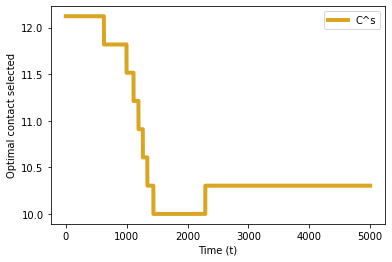

In [6]:
Cs = instance_adaptive.cs_history
cs_unistep = []
for i in tqdm(range(len(Cs))):
    cs_unistep = cs_unistep + [Cs[i]]*instance_adaptive.steps

plt.plot(np.linspace(0, instance_adaptive.t_max, len(cs_unistep)), cs_unistep, 'goldenrod', label="C^s", linewidth=4, )
plt.xlabel("Time (t)")
plt.ylabel("Optimal contact selected")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 757.18it/s]


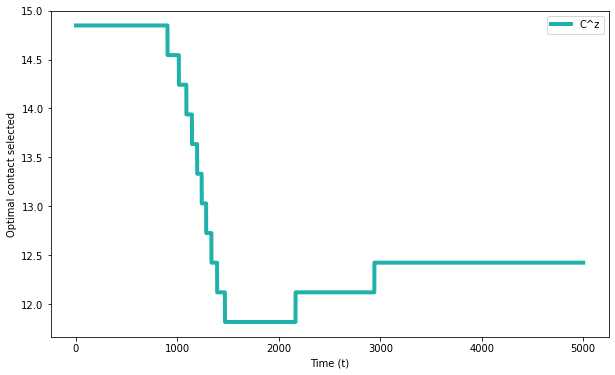

In [7]:
Cs = instance_adaptive.cz_history
cs_unistep = []
for i in tqdm(range(len(Cs))):
    cs_unistep = cs_unistep + [Cs[i]]*instance_adaptive.steps

plt.plot(np.linspace(0, instance_adaptive.t_max, len(cs_unistep)), cs_unistep, 'lightseagreen', label="C^z", linewidth=4, )
plt.xlabel("Time (t)")
plt.ylabel("Optimal contact selected")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

In [8]:
Cs = instance_adaptive.cs_history
cs_unistep = []
for i in tqdm(range(len(Cs))):
    cs_unistep = cs_unistep + [Cs[i]]*instance_adaptive.steps
    
Ci = instance_adaptive.ci_history
ci_unistep = []
for i in tqdm(range(len(Ci))):
    ci_unistep = ci_unistep + [Ci[i]]*instance_adaptive.steps
    
Cz = instance_adaptive.cz_history
cz_unistep = []
for i in tqdm(range(len(Cs))):
    cz_unistep = cz_unistep + [Cz[i]]*instance_adaptive.steps
    
kappas = [ci_unistep[i]/cs_unistep[i] for i in range(len(cs_unistep))]
thetas = [cz_unistep[i]/cs_unistep[i] for i in range(len(cs_unistep))]

print(thetas[0])
print(thetas[-1])

print(kappas[0])
print(kappas[-1])

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 806.24it/s]


1.225
1.2058823529411764
0.825
0.9705882352941176


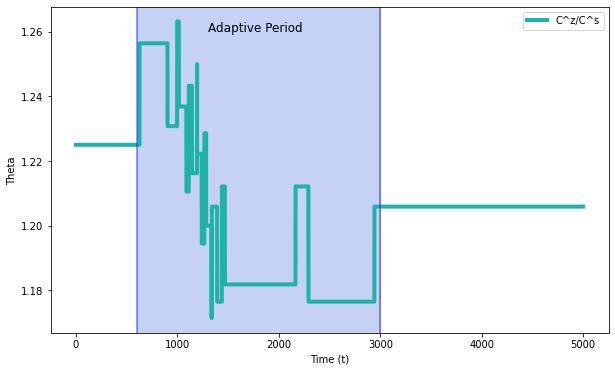

In [9]:
fig, ax = plt.subplots()
ax.plot(np.linspace(0, instance_adaptive.t_max, len(cs_unistep)), thetas,
         'lightseagreen', label="C^z/C^s", linewidth=4, )
ax.axvline(x = 600, color = 'b', alpha=0.5)
ax.axvline(x = 3000, color = 'b', alpha=0.5)
ax.axvspan(600, 3000, alpha=0.3, color='royalblue')

ax.text(1300, 1.26, r'Adaptive Period', fontsize=12)
plt.xlabel("Time (t)")
plt.ylabel("Theta")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

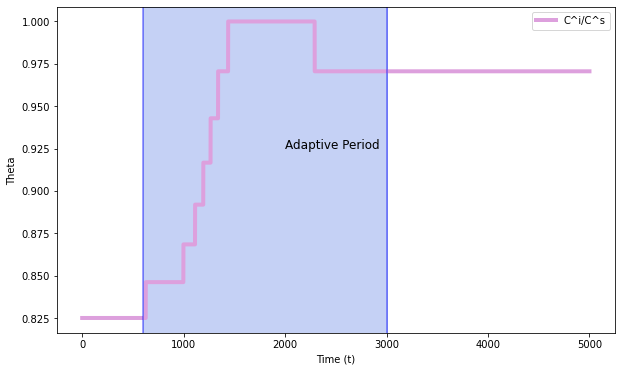

In [10]:
fig, ax = plt.subplots()
ax.plot(np.linspace(0, instance_adaptive.t_max, len(cs_unistep)), kappas,
         'plum', label="C^i/C^s", linewidth=4, )
ax.axvline(x = 600, color = 'b', alpha=0.5)
ax.axvline(x = 3000, color = 'b', alpha=0.5)
ax.axvspan(600, 3000, alpha=0.3, color='royalblue')

ax.text(2000, 0.925, r'Adaptive Period', fontsize=12)
plt.xlabel("Time (t)")
plt.ylabel("Theta")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 769.22it/s]


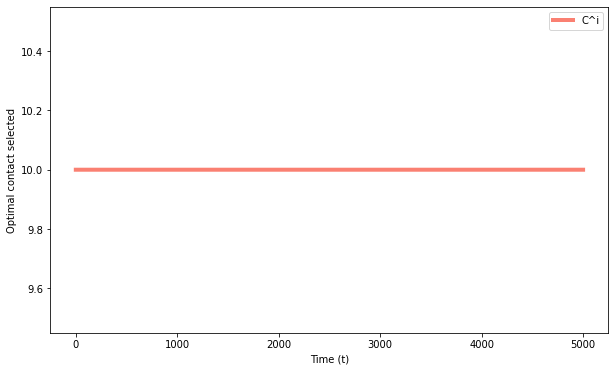

In [11]:
Cs = instance_adaptive.ci_history
cs_unistep = []
for i in tqdm(range(len(Cs))):
    cs_unistep = cs_unistep + [Cs[i]]*instance_adaptive.steps

plt.plot(np.linspace(0, instance_adaptive.t_max, len(cs_unistep)), cs_unistep, 'salmon', label="C^i", linewidth=4, )
plt.xlabel("Time (t)")
plt.ylabel("Optimal contact selected")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

### Plot solution of the system through time

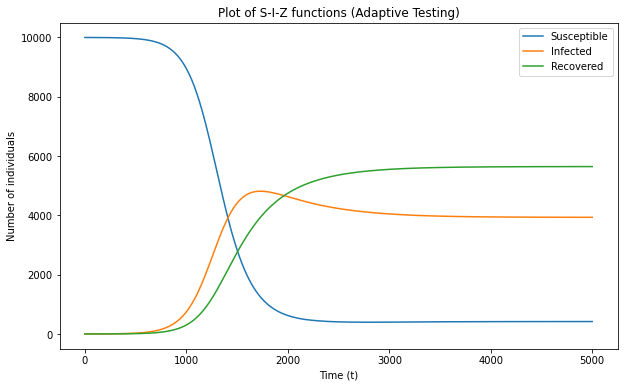

In [12]:
t = np.linspace(0, instance_adaptive.t_max, len(instance_adaptive.S))
instance_adaptive.plot_ode_solution(t = t, title = 'Adaptive Testing')

### Comparison with NON Adaptive models

In [4]:
start = time.time()
# To compare, we take the Cs obtained at the start (ex ante) and at the end (ex post)

instance_non_adaptive_ex_ante = NonAdaptive(
    mu, gamma, beta, phi,
    instance_adaptive.cs_history[0],
    instance_adaptive.ci_history[0],
    instance_adaptive.cz_history[0], x00, t_max)

instance_non_adaptive_ex_post = NonAdaptive(
    mu, gamma, beta, phi,
    instance_adaptive.cs_history[-1],
    instance_adaptive.ci_history[-1],
    instance_adaptive.cz_history[-1], x00, t_max)

instance_non_adaptive_ex_ante.solve_odes_system()
instance_non_adaptive_ex_post.solve_odes_system()

end = time.time()
print(f"Running the NON adaptive algorithms took {end - start} seconds.")

100%|███████████████████████████████████████████████████████████████████████| 500001/500001 [00:34<00:00, 14407.38it/s]


Running the NON adaptive algorithms took 70.8952202796936 seconds.




Proportions and contacts.

Ex ante:
    - Cs: 12.121212121212121
    - Ci: 10.0
    - Cz: 14.84848484848485
    - kappa: 0.825
    - theta: 1.225
    
Ex post:
    - Cs: 10.303030303030303
    - Ci: 10.0
    - Cz: 12.424242424242424
    - kappa: 0.9705882352941176
    - theta: 1.2058823529411764

---- Final Points Attained ------------

Ex ante:  0.39510210279257163
Ex post:  0.3934389345748676
Adaptive: 0.39348023238418495

Theoretical Convergence Points:

Ex ante: []
Ex post: []

R0 Non Adaptive:

Ex ante: 0.3368421052631579
Ex post: 0.3368421052631579


Epidemic Maximum:

Ex ante:  4936.871974499804
Ex post:  4815.537279707531
Adaptive: 4815.539074485804

Time Epidemic Maximum is achieved:

Ex ante:  1699.16
Ex post:  1737.94
Adaptive: 1747.42

------------------------------



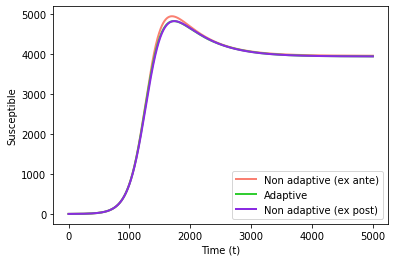

In [5]:
R0_ante = instance_non_adaptive_ex_ante.I[0]*beta/(gamma + mu)
R0_post = instance_non_adaptive_ex_post.I[0]*beta/(gamma + mu)

kappa_ante = instance_adaptive.ci_history[0]/instance_adaptive.cs_history[0]
theta_ante = instance_adaptive.cz_history[0]/instance_adaptive.cs_history[0]

kappa_post = instance_adaptive.ci_history[-1]/instance_adaptive.cs_history[-1]
theta_post = instance_adaptive.cz_history[-1]/instance_adaptive.cs_history[-1]

print(f"""

Proportions and contacts.

Ex ante:
    - Cs: {instance_adaptive.cs_history[0]}
    - Ci: {instance_adaptive.ci_history[0]}
    - Cz: {instance_adaptive.cz_history[0]}
    - kappa: {kappa_ante}
    - theta: {theta_ante}
    
Ex post:
    - Cs: {instance_adaptive.cs_history[-1]}
    - Ci: {instance_adaptive.ci_history[-1]}
    - Cz: {instance_adaptive.cz_history[-1]}
    - kappa: {kappa_post}
    - theta: {theta_post}

---- Final Points Attained ------------

Ex ante:  {instance_non_adaptive_ex_ante.I[-1]/sum(x00)}
Ex post:  {instance_non_adaptive_ex_post.I[-1]/sum(x00)}
Adaptive: {instance_adaptive.I[-1]/sum(x00)}

Theoretical Convergence Points:

Ex ante: {poly_utils.solve_polynomial(Rphi, Rmu, R0_ante, kappa_ante, theta_ante)}
Ex post: {poly_utils.solve_polynomial(Rphi, Rmu, R0_post, kappa_post, theta_post)}

R0 Non Adaptive:

Ex ante: {R0_ante}
Ex post: {R0_post}


Epidemic Maximum:

Ex ante:  {np.max(instance_non_adaptive_ex_ante.I)}
Ex post:  {np.max(instance_non_adaptive_ex_post.I)}
Adaptive: {np.max(instance_adaptive.I)}

Time Epidemic Maximum is achieved:

Ex ante:  {instance_non_adaptive_ex_ante.I.tolist().index(np.max(instance_non_adaptive_ex_ante.I))/steps}
Ex post:  {instance_non_adaptive_ex_post.I.tolist().index(np.max(instance_non_adaptive_ex_post.I))/steps}
Adaptive: {instance_adaptive.I.tolist().index(np.max(instance_adaptive.I))/steps}

------------------------------
""")

plt.plot(
    np.linspace(0,t_max,len(instance_non_adaptive_ex_ante.I)),
    instance_non_adaptive_ex_ante.I, "salmon", label="Non adaptive (ex ante)", linewidth=2)
plt.plot(
    np.linspace(0,t_max,len(instance_adaptive.I)),
    instance_adaptive.I, "limegreen", label="Adaptive", linewidth=2)
plt.plot(
    np.linspace(0,t_max,len(instance_non_adaptive_ex_post.I)),
    instance_non_adaptive_ex_post.I, "blueviolet", label="Non adaptive (ex post)", linewidth=2)

# plt.axvline(x = 2400, color = 'b')

plt.xlabel("Time (t)")
plt.ylabel("Susceptible")
plt.legend(loc = "lower right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

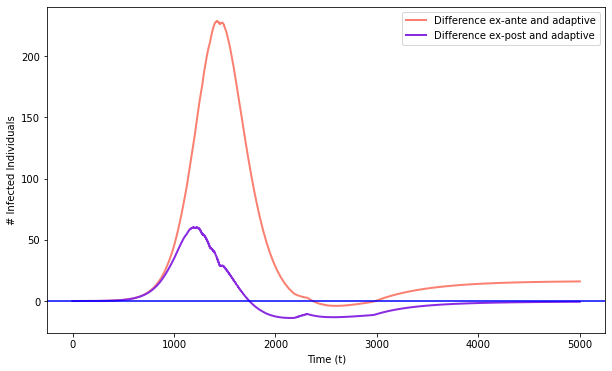

In [6]:
diff_ante_adaptive = [instance_non_adaptive_ex_ante.I[i] - instance_adaptive.I[i] for i in range(len(instance_non_adaptive_ex_ante.I))]
diff_post_adaptive = [instance_non_adaptive_ex_post.I[i] - instance_adaptive.I[i] for i in range(len(instance_non_adaptive_ex_post.I))]

plt.plot(
    np.linspace(0,t_max,len(instance_non_adaptive_ex_ante.I)),
    diff_ante_adaptive, "salmon", label="Difference ex-ante and adaptive", linewidth=2)
plt.plot(
    np.linspace(0,t_max,len(instance_non_adaptive_ex_ante.I)),
    diff_post_adaptive, "blueviolet", label="Difference ex-post and adaptive", linewidth=2)

plt.axhline(y = 0, color = 'b')

plt.xlabel("Time (t)")
plt.ylabel("# Infected Individuals")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

### Other Comparisons

*Infection parameter matters*

Note that $\beta$ is present at the formulation of the transition probability: $P_{si}(a) = 1 - \exp\left(\frac{-\beta\cdot a \cdot C_i^*I}{S(t)\cdot C_s^* +I(t)\cdot C_i^* + Z(t)\cdot C_z^*}\right)$, making this probability close to zero if $\beta$ is small.

Reducing $\beta$ thus reduces the posibility of altering the selection of contact rates at the adaptive algorithm. Here's the same example from above, with a smaller $\beta$, we can see that the adaptive behavior is less variable (meaning that it deviates less from the optimal point of the utility function).

In [17]:
effect_of_beta = pd.read_csv(r"C:\Users\jimmy\OneDrive\Desktop\Maestria Metodos Matematicos y Aplicaciones\Tesis\adaptive\code\adaptive\data\effect_of_beta_1.csv")

In [18]:
effect_of_beta.head(4)

,Unnamed: 0,beta,min_cs,peak_i
0,0,0.050000,5.0,1.0
1,1,0.050505,5.0,1.0
2,2,0.051010,5.0,1.0
3,3,0.051515,5.0,1.0


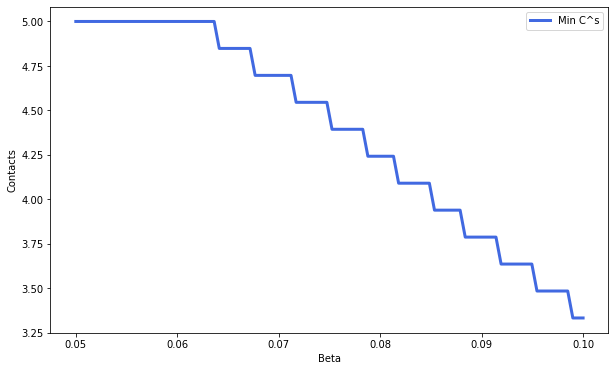

In [19]:
plt.plot(effect_of_beta['beta'],
         effect_of_beta['min_cs'], "royalblue", label="Min C^s", linewidth=3)
plt.xlabel("Beta")
plt.ylabel("Contacts")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

In [20]:
effect_of_tau1 = pd.read_csv(r"C:\Users\jimmy\OneDrive\Desktop\Maestria Metodos Matematicos y Aplicaciones\Tesis\adaptive\code\adaptive\data\effect_of_tau_1.csv")

In [21]:
effect_of_tau1.head(2)

,Unnamed: 0,tau,min_cs,peak_i
0,0,2,4.393939,983.684100
1,1,4,4.090909,937.640917


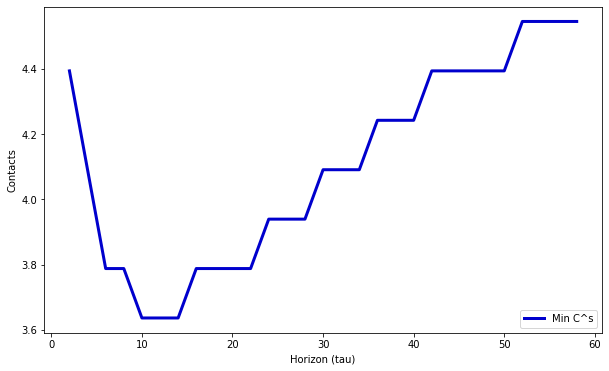

In [22]:
plt.plot(effect_of_tau1['tau'],
         effect_of_tau1['min_cs'], "mediumblue", label="Min C^s", linewidth=3)
plt.xlabel("Horizon (tau)")
plt.ylabel("Contacts")
plt.legend(loc = "lower right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

Changing $a_i=0$ in the non relapse model modifies the behavior of the previous plot.

In [23]:
effect_of_tau2 = pd.read_csv(r"C:\Users\jimmy\OneDrive\Desktop\Maestria Metodos Matematicos y Aplicaciones\Tesis\adaptive\code\adaptive\data\effect_of_tau_2.csv")

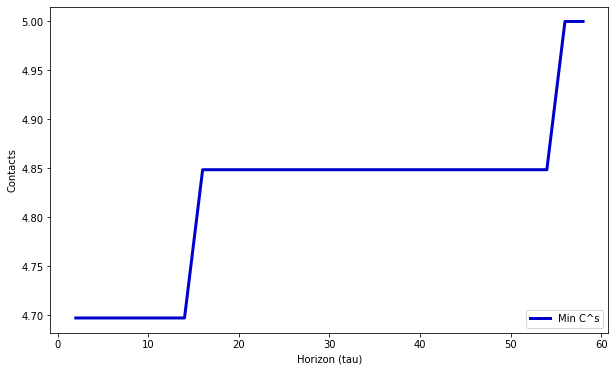

In [24]:
plt.plot(effect_of_tau2['tau'],
         effect_of_tau2['min_cs'], "mediumblue", label="Min C^s", linewidth=3)
plt.xlabel("Horizon (tau)")
plt.ylabel("Contacts")
plt.legend(loc = "lower right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

#### Modifying utility functions:
Effect of shape of utility function.

In [25]:
# ================================================== #

# Initial parameters (Example from Fenichel et al):
mu = 0
gamma = 0.1823
beta = 0.0925
phi = 0

# R values:
Rmu = mu/(mu+ gamma)
Rphi = phi/(mu + gamma)

### Adaptive parameters

# Quadratic Utility functions:

b_s = 10 # Making the max utility attained at b_s/2 
b_i = 6.67 # Making the max utility attained at b_i/2 
b_z = 10 # Making the max utility attained at b_z/2 
a_s = 0
a_i = 1.826
a_z = 0
nu = 0.25
tau = 12
delta = 0.99986

### Simulation parameters
t_max = 150
steps = 100
x00 = [9999, 1, 0]

# Usual utility functions
def u_i(a):
    return (b_i*a - a**2)**nu - a_i
def u_z(a):
    return (b_z*a - a**2)**nu - a_z

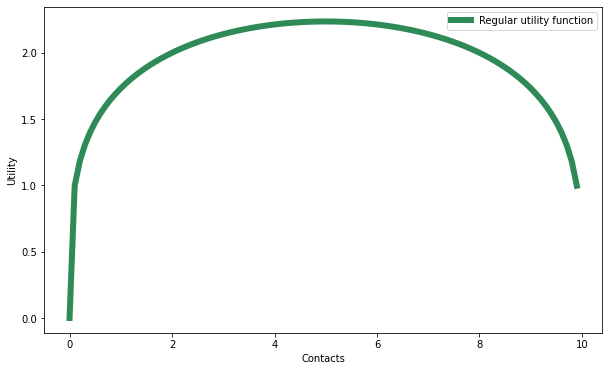

Max value of u_s: 2.23606797749979
Optimal point of u_s: 5.000000000000002
Max value of du_s/da: 0.009870464520087108


In [26]:
def u_s_orig(a):
    return (b_s*a - a**2)**nu - a_s

x_new = np.arange(0, 10, 0.1)
plt.plot(x_new, [u_s_orig(xx) for xx in x_new], 'seagreen',
         label="Regular utility function", linewidth=6)
plt.xlabel("Contacts")
plt.ylabel("Utility")
plt.legend()
plt.show()
x_new = np.arange(3, 7, 0.1)
vals_orig = [u_s_orig(a) for a in x_new]
max_vals_orig = np.nanmax(vals_orig)
gradient_orig = np.gradient(vals_orig)
max_gradient_orig = np.nanmax(gradient_orig)
print(f"Max value of u_s: {max_vals_orig}")
print(f"Optimal point of u_s: {x_new[vals_orig.index(max_vals_orig)]}")
print(f"Max value of du_s/da: {max_gradient_orig}")

[ 0.00000000e+00  9.33747416e-01 -9.74361649e-02 -1.35438200e-03
  2.76052433e-04]


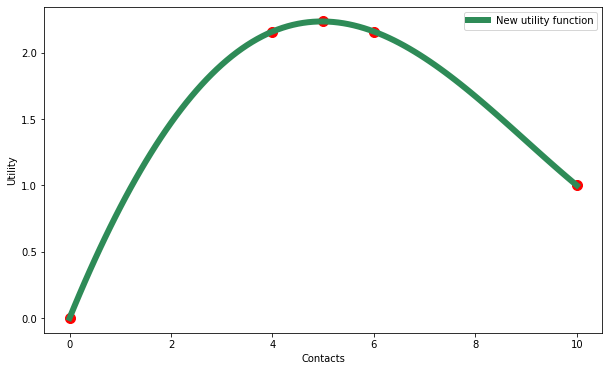

Max value of u_s: 2.2360679774997854
Optimal point of u_s: 5.000000000000002
Max value of du_s/da: 0.03329237565704957


In [28]:
x = np.array([0, 4, 5, 6, 10])
y = np.array([0, 2.16, max_vals_orig, 2.16, 1])

poly = lagrange(x, y)
coeffs = Polynomial(poly.coef[::-1]).coef
print(coeffs)
x_new = np.arange(0, 10.1, 0.1)

plt.plot(x_new, sum([coeffs[i]*x_new**i for i in range(len(coeffs))]),
         'seagreen',
         label="New utility function", linewidth=6)
plt.scatter(x, y, color = 'red', s=100)

plt.xlabel("Contacts")
plt.ylabel("Utility")
plt.legend()
plt.show()

# Change immediate reward to one with multiple optimal points:
def u_s(a):
    if a > 10:
        return 0
    else:
        return sum([coeffs[i]*a**i for i in range(len(coeffs))])

x_new = np.arange(3, 7, 0.1)
vals = [u_s(a) for a in x_new]
max_vals = np.nanmax(vals)
gradient = np.gradient(vals)
max_gradient = np.nanmax(gradient)
print(f"Max value of u_s: {max_vals}")
print(f"Optimal point of u_s: {x_new[vals.index(max_vals)]}")
print(f"Max value of du_s/da: {max_gradient}")

In [29]:
# Initialize adaptive instances
instance_adaptive = Adaptive(
    mu, gamma, beta, phi,
    tau, delta,
    u_s, u_i, u_z,
    t_max, steps, x00, max_contacts=30,
    logs=False,
    verbose=False,
    compute_max_t_threshold=1e-6)
start = time.time()
instance_adaptive.patch_uni_solutions()
end = time.time()
print(f"Running the adaptive algorithm took {(end - start)/60} minutes.")

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:18<00:00,  8.19it/s]

Running the adaptive algorithm took 0.30521814823150634 minutes.


100%|█████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 20059.48it/s]


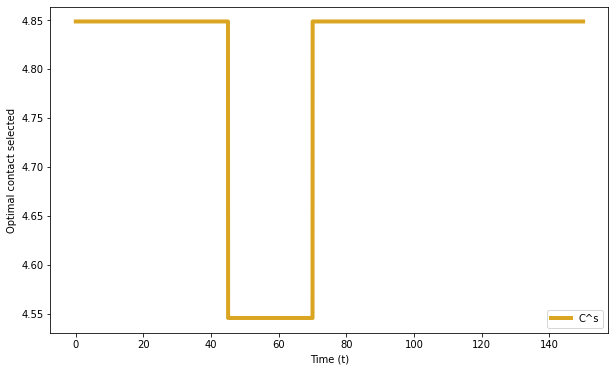

In [30]:
Cs = instance_adaptive.cs_history
cs_unistep = []
for i in tqdm(range(len(Cs))):
    cs_unistep = cs_unistep + [Cs[i]]*instance_adaptive.steps

plt.plot(np.linspace(0, instance_adaptive.t_max, len(cs_unistep)), cs_unistep, 'goldenrod', label="C^s", linewidth=4, )
plt.xlabel("Time (t)")
plt.ylabel("Optimal contact selected")
plt.legend(loc = "lower right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

### Bifurcation plots in the adaptive setting

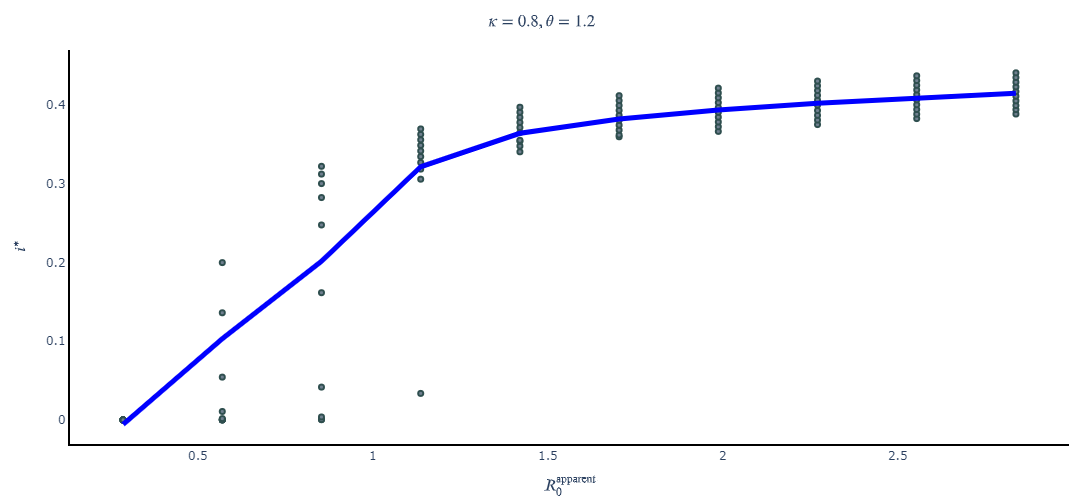

In [5]:
kappa = 0.8
theta = 1.2
folder = "C:/Users/jimmy/OneDrive/Desktop/Maestria Metodos Matematicos y Aplicaciones/Tesis/adaptive/code/adaptive/data/bifurcation_heatmap_adaptive"
data = pd.read_csv(f"{folder}/simulation_adaptive_bifurcation_{kappa}_{theta}.csv")
data = data[['R0', 'final_conv_inf_point', 'final_stopping_point', 'kappa', 'theta', 'prop']]
data = data[~data['R0'].str.endswith('ERROR')]
data['R0'] = data['R0'].astype(float)
data = data[data['R0']<=3]

fig = px.scatter(data, x="R0",
                 y="final_conv_inf_point",
                 trendline="lowess",
                 trendline_options=dict(frac=0.5),
                 width=500,
                 height=500,
                 labels={
                     "final_conv_inf_point": "$i^*$",
                     "R0": "$R_0^{\\text{apparent}}$"
                 },)
fig.update_layout(
    margin=dict(l=70, r=20, t=50, b=20),
    plot_bgcolor='rgba(0,0,0,0)')
fig.update_traces(marker=dict(size=5,
                              color='slategray',
                              line=dict(
                                  width=2,
                                  color='DarkSlateGrey')),
                  selector=dict(mode='markers'),
                 hovertemplate="<br>".join([
                     "R0: %{x}",
                     "i*: %{y}",
                 ]))
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
fig.update_layout(title_text=f"$\\kappa = {kappa}, \\theta = {theta}$)", title_x=0.5)
# This styles the line
fig.update_traces(line=dict(color="blue", width=5))
fig.show()